In [ ]:
import os

import cv2
import numpy as np
import pandas as pd
import scipy

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 0. Настройка основных параметров

In [ ]:
# Main folder path
PROJECT_FOLDER = '/content/drive/MyDrive/AI/IVision'

In [ ]:
# Other folders
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'datasets')
DATA_CSV = os.path.join(PROJECT_FOLDER, 'data.csv')

DATASET_FOLDER = os.path.join(DATA_FOLDER, 'final_no_leak')
DATASETS_FOLDERS = {
    'train': os.path.join(DATASET_FOLDER, 'train'),
    'val': os.path.join(DATASET_FOLDER, 'val'),
    'test': os.path.join(DATASET_FOLDER, 'test')
}

MODEL_FOLDER = os.path.join(PROJECT_FOLDER, 'model')
MODEL_PATH = os.path.join(MODEL_FOLDER, 'ModelTF.h5')

In [ ]:
# Model params
BATCH_SIZE = 100
IMAGE_SIZE = (250, 250)  # im_height, im_width

# 1. Данные

## 1.1. Загрузка данных

In [ ]:
# Create dict with dataset folders
for k, v in DATASETS_FOLDERS.items():
  if not os.path.exists(v):
    print(f"Dataset '{k}' with folder '{v}' doesn't exists!")

DATASETS_FOLDERS

{'test': '/content/drive/MyDrive/AI/IVision/datasets/final_no_leak/test',
 'train': '/content/drive/MyDrive/AI/IVision/datasets/final_no_leak/train',
 'val': '/content/drive/MyDrive/AI/IVision/datasets/final_no_leak/val'}

In [ ]:
# Create datasets: 'train', 'val' and 'test'
datasets = {}

for dataset_type, dataset_folder in DATASETS_FOLDERS.items():
  datasets[dataset_type] = tf.keras.preprocessing.image_dataset_from_directory(
      dataset_folder,
      seed=42,
      image_size = IMAGE_SIZE,
      batch_size = BATCH_SIZE
  )

datasets

Found 1338 files belonging to 2 classes.
Found 699 files belonging to 2 classes.
Found 241 files belonging to 2 classes.


{'test': <BatchDataset shapes: ((None, 250, 250, 3), (None,)), types: (tf.float32, tf.int32)>,
 'train': <BatchDataset shapes: ((None, 250, 250, 3), (None,)), types: (tf.float32, tf.int32)>,
 'val': <BatchDataset shapes: ((None, 250, 250, 3), (None,)), types: (tf.float32, tf.int32)>}

## 1.2. Настройка наборов данных

In [ ]:
class_names = datasets['train'].class_names

AUTOTUNE = tf.data.experimental.AUTOTUNE
datasets['train'] = datasets['train'].cache().prefetch(buffer_size=AUTOTUNE)
datasets['test'] = datasets['test'].prefetch(buffer_size=AUTOTUNE)

# 2. Модель

Добавим для модели дополнительно 3 аугментации: GaussianNoise, горизонтальный RandomFlip и RandomContrast.

In [ ]:
MyCnn = tf.keras.models.Sequential([
  layers.GaussianNoise(0.2),
  layers.RandomFlip(mode='horizontal'),
  layers.RandomContrast(factor=[0.2, 0.4]),
  
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3. Обучение

## 3.1. Процесс обучения

Настроим сохранение модели по максимальному значению метрики `val_accuracy`.

In [ ]:
checkpoint_filepath = os.path.join(MODEL_FOLDER, 'weights.epoch:{epoch:02d}-val_loss:{val_loss:.2f}-val_accuracy:{val_accuracy:.2f}.h5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Процесс обучения классификатора

In [ ]:
retVal = MyCnn.fit(datasets['train'],
                   validation_data = datasets['val'],
                   epochs = 20,
                   callbacks=[model_checkpoint_callback])

Epoch 1/20
14/14 [==============================] - 216s 15s/step - loss: 3.7267 - accuracy: 0.6861 - val_loss: 1.3614 - val_accuracy: 0.8169
Epoch 2/20
14/14 [==============================] - 210s 15s/step - loss: 0.4199 - accuracy: 0.8064 - val_loss: 0.7579 - val_accuracy: 0.8169
Epoch 3/20
14/14 [==============================] - 218s 16s/step - loss: 0.3155 - accuracy: 0.8445 - val_loss: 1.0112 - val_accuracy: 0.8169
Epoch 4/20
14/14 [==============================] - 209s 15s/step - loss: 0.2727 - accuracy: 0.8430 - val_loss: 0.6529 - val_accuracy: 0.8169
Epoch 5/20
14/14 [==============================] - 213s 15s/step - loss: 0.2459 - accuracy: 0.8595 - val_loss: 0.8130 - val_accuracy: 0.8169
Epoch 6/20
14/14 [==============================] - 217s 16s/step - loss: 0.2387 - accuracy: 0.8617 - val_loss: 0.7810 - val_accuracy: 0.8169
Epoch 7/20
14/14 [==============================] - 208s 15s/step - loss: 0.2208 - accuracy: 0.8827 - val_loss: 0.7654 - val_accuracy: 0.8083
Epoch 

История обучения модели:
```

Epoch 1/20
14/14 [==============================] - 216s 15s/step - loss: 3.7267 - accuracy: 0.6861 - val_loss: 1.3614 - val_accuracy: 0.8169
Epoch 2/20
14/14 [==============================] - 210s 15s/step - loss: 0.4199 - accuracy: 0.8064 - val_loss: 0.7579 - val_accuracy: 0.8169
Epoch 3/20
14/14 [==============================] - 218s 16s/step - loss: 0.3155 - accuracy: 0.8445 - val_loss: 1.0112 - val_accuracy: 0.8169
Epoch 4/20
14/14 [==============================] - 209s 15s/step - loss: 0.2727 - accuracy: 0.8430 - val_loss: 0.6529 - val_accuracy: 0.8169
Epoch 5/20
14/14 [==============================] - 213s 15s/step - loss: 0.2459 - accuracy: 0.8595 - val_loss: 0.8130 - val_accuracy: 0.8169
Epoch 6/20
14/14 [==============================] - 217s 16s/step - loss: 0.2387 - accuracy: 0.8617 - val_loss: 0.7810 - val_accuracy: 0.8169
Epoch 7/20
14/14 [==============================] - 208s 15s/step - loss: 0.2208 - accuracy: 0.8827 - val_loss: 0.7654 - val_accuracy: 0.8083
Epoch 8/20
14/14 [==============================] - 215s 16s/step - loss: 0.1905 - accuracy: 0.9111 - val_loss: 0.8522 - val_accuracy: 0.7353
Epoch 9/20
14/14 [==============================] - 212s 15s/step - loss: 0.1809 - accuracy: 0.9088 - val_loss: 0.9512 - val_accuracy: 0.8441
Epoch 10/20
14/14 [==============================] - 210s 15s/step - loss: 0.1708 - accuracy: 0.9185 - val_loss: 0.9027 - val_accuracy: 0.7482
Epoch 11/20
14/14 [==============================] - 218s 16s/step - loss: 0.1700 - accuracy: 0.9170 - val_loss: 0.9019 - val_accuracy: 0.6295
Epoch 12/20
14/14 [==============================] - 213s 15s/step - loss: 0.1268 - accuracy: 0.9462 - val_loss: 1.1481 - val_accuracy: 0.6695
Epoch 13/20
14/14 [==============================] - 212s 15s/step - loss: 0.1198 - accuracy: 0.9544 - val_loss: 1.1899 - val_accuracy: 0.6423
Epoch 14/20
14/14 [==============================] - 210s 15s/step - loss: 0.1091 - accuracy: 0.9596 - val_loss: 1.4326 - val_accuracy: 0.6753
Epoch 15/20
14/14 [==============================] - 209s 15s/step - loss: 0.0979 - accuracy: 0.9589 - val_loss: 1.4714 - val_accuracy: 0.6681
Epoch 16/20
14/14 [==============================] - 215s 16s/step - loss: 0.0883 - accuracy: 0.9656 - val_loss: 1.4901 - val_accuracy: 0.6638
Epoch 17/20
14/14 [==============================] - 209s 15s/step - loss: 0.0888 - accuracy: 0.9567 - val_loss: 1.2664 - val_accuracy: 0.6767
Epoch 18/20
14/14 [==============================] - 211s 15s/step - loss: 0.0987 - accuracy: 0.9581 - val_loss: 1.3851 - val_accuracy: 0.5637
Epoch 19/20
14/14 [==============================] - 213s 15s/step - loss: 0.0724 - accuracy: 0.9694 - val_loss: 1.6362 - val_accuracy: 0.6166
Epoch 20/20
14/14 [==============================] - 210s 15s/step - loss: 0.0621 - accuracy: 0.9723 - val_loss: 1.6325 - val_accuracy: 0.5851
```



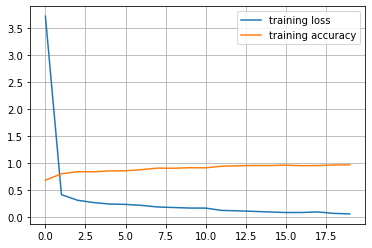

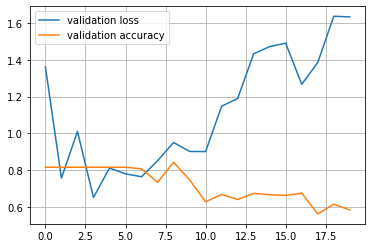

In [ ]:
# Train data plot
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Val data plot
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()
plt.show()

## 3.2. Загрузка лучших весов

In [ ]:
def sort_func(x):
  _, val_loss, val_acc = x[:-3].split('-')
  val_loss = float(val_loss.split(':')[-1])
  val_acc = float(val_acc.split(':')[-1])

  return 1-val_acc, val_loss

weights = os.listdir(MODEL_FOLDER)
best_weights_path = os.path.join(MODEL_FOLDER, sorted(weights, key=sort_func)[0])
MyCnn.load_weights(best_weights_path)

Проверка качества, что корректные веса были загружены

In [ ]:
def get_accuracy(model, dataset):
  preds = []
  targets = []

  for images, labels in dataset:
      predictions = model.predict(images)
      targets.append(labels)
      preds.append(predictions)

  return (np.argmax(np.concatenate(preds), axis=1) == np.concatenate(targets)).mean()

print(f"Качество на валидационном наборе данных: {get_accuracy(MyCnn, datasets['val'])}")

Качество на валидационном наборе данных: 0.844062947067239


## 3.3. Проверка качества на тесте

In [ ]:
get_accuracy(MyCnn, datasets['test'])
print(f"Качество на тестовом наборе данных: {get_accuracy(MyCnn, datasets['test'])}")

Качество на тестовом наборе данных: 0.6763485477178424


## 3.4. Сохранение лучшей модели

In [ ]:
MyCnn.save(MODEL_PATH)

# 4. Тестирование модели на видео

## 4.1. Скоринг всех видео

In [ ]:
def predict_video(model, video_path):

  cap = cv2.VideoCapture(video_path)
  batch = []
  probs_0 = []  # accident
  probs_1 = []  # no accident

  while(cap.isOpened()):
      ret, frame = cap.read()
      if len(batch) < BATCH_SIZE and ret == True:
        batch.append(cv2.resize(frame, IMAGE_SIZE))

      elif len(batch) >= BATCH_SIZE or ret == False:
        batch = tf.convert_to_tensor(batch, dtype=None, dtype_hint=None, name=None)
        predictions = model.predict(batch)

        probs_0.append(predictions[:,0])
        probs_1.append(predictions[:,1])

        batch = []

      if ret == False:
        break
  
  cap.release()

  probs_0, probs_1 = np.concatenate(probs_0), np.concatenate(probs_1)

  return probs_0, probs_1

Рассмотрим подсчет двух эвристик, по которым можно сделать отсечку, и сказать, что на видео произошла авария. Первая - std для значений выше среднего, вторая - std для значений выше моды.

In [ ]:
from tqdm import tqdm

all_probs_0 = []
all_probs_1 = []
evr1 = []  # mean
evr2 = []  # mode 
vid = []

for video_name in tqdm(os.listdir(DATA_FOLDER)):
  if video_name.split('.')[-1]!='mp4':
    continue

  vid.append(video_name)
  video_path = os.path.join(DATA_FOLDER, video_name)
  probs_0, probs_1 = predict_video(MyCnn, video_path)

  all_probs_0.append(probs_0)
  all_probs_1.append(probs_1)

  evr1.append(probs_0[probs_0 >= np.mean(probs_0)].std())  # mean
  evr2.append(probs_0[probs_0 >= scipy.stats.mode(probs_0)[0][0]].std())  # mode

100%|██████████| 55/55 [1:57:33<00:00, 128.25s/it]


## 4.2. Собираем набор данных с нашими эвристиками

In [ ]:
import pandas as pd

data_df = pd.read_csv(DATA_CSV)
data_df['video'] = data_df['video'].astype(dtype=str)

evs_data = np.stack([[i.split('.mp4')[0] for i in vid], evr1, evr2], axis=1)
evr_df = pd.DataFrame(data = evs_data,
                      columns = ['video', 'evr_mean', 'evr_mode'])

merge_df = evr_df.merge(data_df, on='video').reset_index(drop=True)

## 4.3. Ищем лучшую отсечку для определения аварии

In [ ]:
def find_best_th(df):

  best_sum_acc = 0
  best_th = 0
  best_type = None

  for evr_type in ['evr_mode', 'evr_mean']:
    crash = df[df['crash_happened']==1][[evr_type]].astype(dtype=float).to_numpy().flatten()
    no_crash = df[df['crash_happened']==0][[evr_type]].astype(dtype=float).to_numpy().flatten()

    for th in np.arange(0.005, 0.5, 0.001):
      sum_acc = sum(crash >= th)/len(crash) + sum(no_crash < th)/len(no_crash)

      if sum_acc >= best_sum_acc:
        best_sum_acc = sum_acc
        best_th = th
        best_type = evr_type

  return best_sum_acc, best_th, best_type


find_best_th(merge_df)

(1.7833333333333332, 0.011, 'evr_mode')

# Вывод

Для скоринга видео необходимо провести видео через обученную ране модель TF, посчитать эвристику относительно моды, и по отсечке 0.011 определить, была ли авария на видео, или нет.